In [ ]:
import os
import shutil

import glob
import numpy as np

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TARGET_PATH = "/content/drive/MyDrive/dataset/cat_raw"
if os.path.exists(TARGET_PATH):
  print(len(os.listdir(TARGET_PATH)))

5


In [ ]:
dataset = []
for filepath in glob.iglob(f"{TARGET_PATH}/**/**.*", recursive = True):
  breed_name = filepath.split("/")[6]
  dataset.append([filepath, breed_name])

dataset = np.array(dataset)
len(dataset)

731

In [ ]:
from sklearn.model_selection import train_test_split

train_image, test_image, train_target, test_target = train_test_split(dataset[:,0], dataset[:,1], test_size = 0.2, stratify=dataset[:,1])
len(train_image), len(test_image)

(584, 147)

In [ ]:
import pandas as pd
# train set 전체 중 각 종 데이터의 비율
pd.Series(train_target).value_counts() / len(train_target)

Sphynx         0.285959
Siamese        0.243151
Munchkin       0.191781
Tri-Color      0.159247
go-deung-eo    0.119863
dtype: float64

In [ ]:
# test set 전체 중 각 종 데이터의 비율
pd.Series(test_target).value_counts() / len(test_target)


Sphynx         0.285714
Siamese        0.244898
Munchkin       0.190476
Tri-Color      0.156463
go-deung-eo    0.122449
dtype: float64

In [ ]:
DATA_PATH = "/content/drive/MyDrive/dataset/cat_edited"
# 데이터를 train과 test로 나눠 넣어 놓을 폴더를 만듦
if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)
  os.makedirs(os.path.join(DATA_PATH, "train"))
  os.makedirs(os.path.join(DATA_PATH, "test"))

  for breed_name in set(test_target):
    os.makedirs(os.path.join(DATA_PATH, "train", breed_name))
    os.makedirs(os.path.join(DATA_PATH, "test", breed_name))

In [ ]:
# train 데이터를 train 폴더에 옮김
for filepath, target_dir in zip(train_image.tolist(), train_target.tolist()):
  filename = filepath.split("/")[-1]
  if filename != "" and filename not in set(test_target):
    source_path = filepath
    target_dir = os.path.join(DATA_PATH, "train", target_dir, filename)
    shutil.copy(source_path, target_dir)

# test 데이터를 test 폴더에 옮김
for filepath, target_dir in zip(test_image.tolist(), test_target.tolist()):
  filename = filepath.split("/")[-1]
  if filename != "" and filename not in set(test_target):
    source_path = filepath
    target_dir = os.path.join(DATA_PATH, "test", target_dir, filename)
    shutil.copy(source_path, target_dir)

['Munchkin' 'Siamese' 'Tri-Color' 'Sphynx' 'go-deung-eo' 'Munchkin'
 'Siamese' 'Tri-Color' 'go-deung-eo' 'Sphynx']


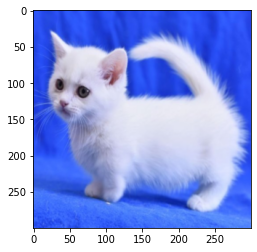

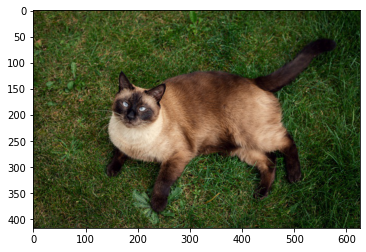

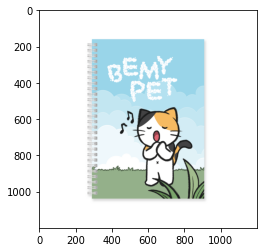

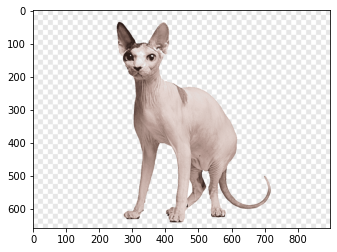

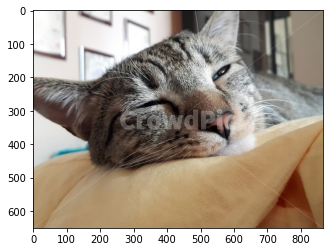

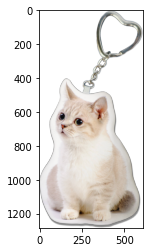

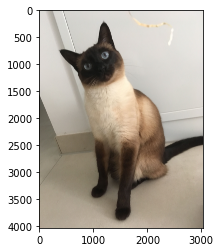

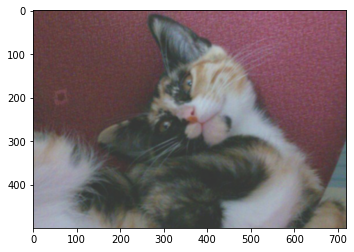

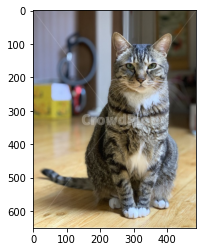

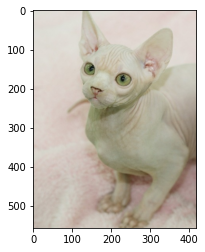

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image)

    
idx = np.random.choice(len(dataset), 10)

images = dataset[:, 0][idx]

for file in images:
    process(file)
    
print(dataset[:, 1][idx])

In [ ]:
from torchvision import datasets, transforms, models

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor()
                                      ])

# accuracy가 더 떨어지기 때문에 수행하지 않은 transform들
#                                       transforms.RandomRotation(30),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.CenterCrop(224),
#                                       transforms.Normalize([0.485, 0.456, 0.406],
#                                                            [0.229, 0.224, 0.225])


test_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor()
                                      ])

# accuracy가 더 떨어지기 때문에 수행하지 않은 transform들
#                                      transforms.CenterCrop(224),
#                                      transforms.Normalize([0.485, 0.456, 0.406],
#                                                           [0.229, 0.224, 0.225])


DATASET_PATH = "/content/drive/MyDrive/dataset/cat_edited"
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

In [ ]:
import torch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax

In [ ]:
data_iter = iter(test_loader)

images, labels = next(data_iter)

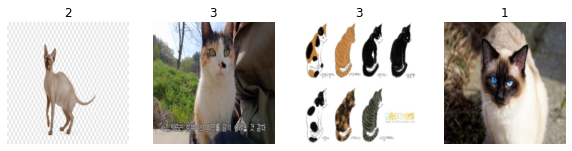

In [ ]:
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, title=labels[i].item(), normalize=False)

In [ ]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0+cu101].
This notebook use [cuda:0].


In [ ]:
EPOCHS = 20
BATCH_SIZE=16
LEARNING_RATE=0.001

In [28]:
class CNN(nn.Module):
    def __init__(self, input_size = [3, 224, 224],
                 hidden_size=[32,64], 
                 num_classes=5, init_weight="he", init_bias="zero"):
        super(CNN, self).__init__()

        self.init_weight = init_weight
        self.init_bias = init_bias

        layer_list = []
        prev_channel = input_size[0]
        
        for idx in range(len(hidden_size)):
            layer_list.append(nn.Conv2d(prev_channel, hidden_size[idx], kernel_size=3, stride=1, padding=1))
            layer_list.append(nn.BatchNorm2d(hidden_size[idx]))
            layer_list.append(nn.ReLU(True))
            layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2))
            layer_list.append(nn.Dropout2d(p=0.5))
            prev_channel = hidden_size[idx]
        
        layer_list.append(nn.Flatten())
        feature_size = int(input_size[1]/ 2**len(hidden_size))
        layer_list.append(nn.Linear(feature_size*feature_size*prev_channel, num_classes))
        
        self.net = nn.Sequential(*layer_list)

        self.init_params()

    def init_params(self):
        
        init_weight_method = {
        "he": nn.init.kaiming_normal_, 
        "xavier": nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'
        
        init_bias_method = {
            "zero": nn.init.zeros_, 
            "uniform": nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weight_method[self.init_weight](m.weight)
                init_bias_method[self.init_bias](m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, X):
        return self.net(X)

model = CNN()

In [29]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 1,023,109


In [30]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 3, 224, 224).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

In [31]:
# Training Phase
print_every = 1
best_accuracy = 0
print("Start training !")

model = CNN(hidden_size=[64, 32, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_loader:

        X = batch_img.view(-1, 3, 224, 224).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate los
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_loader)
        accr_val = test_eval(model, test_loader, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")  

print("Training Done !")


Start training !


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch:[1/20] cost:[12.514] test_accuracy:[38.937]
epoch:[2/20] cost:[9.361] test_accuracy:[48.199]
epoch:[3/20] cost:[8.039] test_accuracy:[57.633]
epoch:[4/20] cost:[7.341] test_accuracy:[52.487]
epoch:[5/20] cost:[7.288] test_accuracy:[62.779]
epoch:[6/20] cost:[7.265] test_accuracy:[70.840]
epoch:[7/20] cost:[5.937] test_accuracy:[78.731]
epoch:[8/20] cost:[4.849] test_accuracy:[78.388]
epoch:[9/20] cost:[4.753] test_accuracy:[77.530]
epoch:[10/20] cost:[4.217] test_accuracy:[80.789]
epoch:[11/20] cost:[3.214] test_accuracy:[74.786]
epoch:[12/20] cost:[3.376] test_accuracy:[85.249]
epoch:[13/20] cost:[2.590] test_accuracy:[77.873]
epoch:[14/20] cost:[2.996] test_accuracy:[89.708]
epoch:[15/20] cost:[2.481] test_accuracy:[82.161]
epoch:[16/20] cost:[1.937] test_accuracy:[89.880]
epoch:[17/20] cost:[2.083] test_accuracy:[89.365]
epoch:[18/20] cost:[2.046] test_accuracy:[93.654]
epoch:[19/20] cost:[1.663] test_accuracy:[93.310]
epoch:[20/20] cost:[1.636] test_accuracy:[95.026]
Training

In [32]:

n_sample = 16
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))
    model.train()
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    ax = plt.subplot(4, 4, idx+1)
    title = f"Predict: {y_pred[idx]}, Label: {test_y[idx]}"
    imshow(test_x[idx], ax, title, normalize = False)

plt.show()

Output hidden; open in https://colab.research.google.com to view.